In [1]:
# import statements

import pandas as pd
import os
import gzip
import requests

import folium
from folium.plugins import MarkerCluster

import matplotlib.pyplot as plt

In [2]:
def get_elevations(bases_geo_df):

    """
    Pulls elevation data from open-elevation.com

            Parameters:
                        bases_geo_df (DataFrame): Latitude and Longitude of each base

            Returns:
                        elevations_df (DataFrame): location and elevation of each base 
    """
    
    elevations = list()

    for lat, long in bases_geo_df['geoPoint'].values:

        location = (f"{lat},{long}")
        
        url = f"https://api.open-elevation.com/api/v1/lookup?locations={location}"
        
        try:

            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            
            if 'results' in data and data['results']:

                elevation = data['results'][0]['elevation']
                elevations.append(elevation)

            else:

                elevations.append(None)
            
        
        except requests.exceptions.RequestException as e:

            print(f"Error: {e}")

            elevations.append(None)
            
    elevations_df = pd.DataFrame({'elevation': elevations})  

    elevations_df = pd.concat([bases_geo_df, elevations_df], axis=1)

    return elevations_df

In [3]:
def data_import_bases(states = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]):

    """
    Returns a cleaned dataframe with all the military installations.

            Parameters:
                        states (list): list of states you want to see bases off

            Data:
                        https://public.opendatasoft.com/explore/dataset/military-bases/export/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6Im1pbGl0YXJ5LWJhc2VzIiwib3B0aW9ucyI6e319LCJjaGFydHMiOlt7ImFsaWduTW9udGgiOnRydWUsInR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQVZHIiwieUF4aXMiOiJvYmplY3RpZF8xIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiI0ZGNTE1QSJ9XSwieEF4aXMiOiJjb21wb25lbnQiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIn1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D&location=6,37.78808,-111.09375&basemap=jawg.light

            Returns:
                        bases_df (DataFrame): 
    """

    # Choose columns we need
    data_columns = ['Geo Point', 'COMPONENT', 'Site Name', 'State Terr', 'Oper Stat']

    # read in alle the military bases - seperator ';'
    bases_df = pd.read_csv('./data/military-bases.csv', sep=';', usecols = data_columns )

    # rename columns for easier use
    bases_df.rename(columns={'Geo Point': 'geoPoint', 'COMPONENT': "component", 'Site Name': 'name', 'State Terr': 'state', 'Oper Stat': 'status'}, inplace = True)

    # checking it there is only Active and Inaktive
    #bases_df[(bases_df.status != 'Active') & (bases_df.status != 'Inactive')]

    # drop all Inaktive bases
    bases_df = bases_df[bases_df.status != 'Inactive']

    # convert geo points
    bases_df[['latitude', 'longitude']] = bases_df['geoPoint'].str.split(',', expand = True).astype('float64')
    bases_df['geoPoint'] = list(zip(bases_df['latitude'], bases_df['longitude']))
    bases_df.drop(columns = ['latitude', 'longitude'], inplace =  True)

    # filter by list of states
    bases_df = bases_df[bases_df.state.isin(states)]

    bases_df.reset_index(drop = True, inplace = True)   
    
    # get elevation for each location 
    bases_df = get_elevations(bases_df)   

    return bases_df



In [4]:
def data_import_tidel_sensors():

    """
    Returns DataFrames with the information about the sensor and the data.

            Parameters:
                        None

            Returns:
                        sensor_information_df (DataFrame): dataframe consisting out of:

                            e.g.
                            NOS ID: 9410170
                            Location Name: SAN DIEGO, SAN DIEGO BAY
                            Latitude: 32.71419
                            Longitude: -117.17358
                            Horizontal Datum: WGS-84
                            Operator: DOC>NOAA>NOS>CO-OPS
                            Vertical Datum: Station Datum

                        sensor_data_df (DataFrame): dataframe consisting of the sensor data
            Source:
                        https://www.ngdc.noaa.gov/hazard/tide/

    """

    # Creating a dictionary to store the metadata and the data
    sensor_information_dict = dict()
    csv_header = list()
    files_in_directory_gz = list()
    sensor_data_df = pd.DataFrame()

    # Getting all the files in the directory
    files_in_directory = os.listdir('./data/tide_sensors')

    if len(files_in_directory) == 0:
        raise ValueError('No files in the directory')

    # Getting all the gz files
    for file in files_in_directory:
        
        # Checking if the file is a gz file
        if file.endswith('.gz'):
            
            # Appending the file to the list
            files_in_directory_gz.append(file)

    # Looping through all the files in the directory
    for idx, file in enumerate(files_in_directory_gz):

        # Reading in the file
        with gzip.open('./data/tide_sensors/' + file, 'rt') as file_in:
            
            # Reading in header
            sensor_information_file = file_in.readlines()[0:10]

        if len(csv_header) == 0:
            # Retrieving the header for csv
            csv_header = sensor_information_file[-1].removeprefix('// ').removesuffix('\n').split(',')
            csv_header = [item.strip() for item in csv_header]

        # Getting metadata for the sensor
        for line in sensor_information_file[:-4]:
            
            name, value = line.removeprefix('// ').strip().split(':')

            if name in sensor_information_dict:
                sensor_information_dict[name].append(value)
            else :
                sensor_information_dict[name] = [value]
        
        # Reading in the data of the sensor
        sensor_data_df_temp = pd.read_csv('./data/tide_sensors/' + file, skiprows=10, sep='\t', header=None, usecols=[0,1])
        sensor_data_df_temp.columns = csv_header[:2]
        sensor_data_df_temp['NOS ID'] = int(sensor_information_dict.get('NOS ID')[idx])
        sensor_data_df_temp['datetime [ISO8601]'] = pd.to_datetime(sensor_data_df_temp['datetime [ISO8601]'], format='ISO8601')
        sensor_data_df = pd.concat([sensor_data_df, sensor_data_df_temp])

    # Creating a df from the metadata
    sensor_information_df = pd.DataFrame(sensor_information_dict)

    sensor_information_df = sensor_information_df.assign(geoPoint = list(zip(sensor_information_df.Latitude.astype('float64'), sensor_information_df.Longitude.astype('float64'))))
    sensor_information_df.drop(columns = ['Latitude', 'Longitude'], inplace =  True)

    return sensor_information_df, sensor_data_df  


In [5]:
def curate_tide_sensor_data(tide_sensor_df):

    """
    Curates the tide sonsor data.

            Parameters:
                        tide_sensor_df (DataFrame): Contains all read in tide sensors

            Returns:
                        curated_tide_sensor_df 
    """

    # Remove all rows with 9999
    tide_sensor_df = tide_sensor_df[tide_sensor_df['waterlevel_quality_controlled [m]'] != 9999]
    # find unique sensors IDs
    tide_sensors = tide_sensor_df['NOS ID'].unique()

    # Group by NOS ID and month
    curated_tide_sensor_mean_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='W')])['waterlevel_quality_controlled [m]'].mean()
    curated_tide_sensor_min_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='W')])['waterlevel_quality_controlled [m]'].min()
    curated_tide_sensor_max_df = tide_sensor_df.groupby(['NOS ID', pd.Grouper(key='datetime [ISO8601]', freq='W')])['waterlevel_quality_controlled [m]'].max()

    # Reset index
    curated_tide_sensor_mean_df = curated_tide_sensor_mean_df.reset_index()
    curated_tide_sensor_min_df = curated_tide_sensor_min_df.reset_index()
    curated_tide_sensor_max_df = curated_tide_sensor_max_df.reset_index()

    # Save Base names for chosen sensors
    # must become dynamic!
    base_names_for_sensors = ['MCB Hawaii, Kaneohe Bay', 'VSTA San Diego', 'MCB Camp Pendleton', 'NAVSUPDET Monterey (NPS)', 'NAVSTA Everett, Washington']

    for idx, sensor in enumerate(tide_sensors):

        # Get the sensor data
        sensor_data = curated_tide_sensor_mean_df[curated_tide_sensor_mean_df['NOS ID'] == sensor]

        # Get the min and max
        sensor_data_min = curated_tide_sensor_min_df[curated_tide_sensor_min_df['NOS ID'] == sensor]
        sensor_data_max = curated_tide_sensor_max_df[curated_tide_sensor_max_df['NOS ID'] == sensor]

        # Merge the data
        sensor_data = sensor_data.merge(sensor_data_min[['datetime [ISO8601]', 'waterlevel_quality_controlled [m]']], on='datetime [ISO8601]')
        sensor_data = sensor_data.merge(sensor_data_max[['datetime [ISO8601]', 'waterlevel_quality_controlled [m]']], on='datetime [ISO8601]')

        # Rename columns
        sensor_data.columns = ['NOS ID', 'datetime', 'mean', 'min', 'max']

        # Plotting min, mean, and max
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(sensor_data['datetime'], sensor_data['min'], label='Min')
        ax.plot(sensor_data['datetime'], sensor_data['mean'], label='Mean')
        ax.plot(sensor_data['datetime'], sensor_data['max'], label='Max')

        # Running average
        sensor_data['ra_min'] = sensor_data['min'].rolling(window=52).mean()
        sensor_data['ra_mean'] = sensor_data['mean'].rolling(window=52).mean()
        sensor_data['ra_max'] = sensor_data['max'].rolling(window=52).mean()

        # Plotting running average
        ax.plot(sensor_data['datetime'], sensor_data['ra_min'], 'r', label='Running average min')
        ax.plot(sensor_data['datetime'], sensor_data['ra_mean'], 'r', label='Running average mean')
        ax.plot(sensor_data['datetime'], sensor_data['ra_max'], 'r', label='Running average max')

        # Set labels and title
        ax.set_xlabel('Date')
        ax.set_ylabel('Water Level (m)')
        ax.set_title(f'Tide Sensor {sensor} - {base_names_for_sensors[idx]}')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

        # Save the plot as an image file
        fig.savefig('./plots/plot_' + str(sensor) + '.png')
        
        #plt.show()

    return None



In [15]:
def create_map(bases_df, sensors_df):

    """
    Creates a map with folium.

            Parameters:
                        bases_df (DataFrame): Contains all US Bases that we want to see in the Map
                        sensors_df (DataFrame): Contains all Sensors that we want to see in the Map

            Returns:
                        None: 
    """

    # folium Map centered on Glasgow Hall
    nps_lat = 36.598802
    nps_lon = -121.877178

    # Create a map object
    # Specify center location, and starting zoom level (0 to 18)
    map = folium.Map(location=[nps_lat, nps_lon], zoom_start = 4, control_scal = True, tiles = "Cartodb Positron")

    # Add a marker for Glasgow Hall
    coord_list_bases = bases_df['geoPoint']
    coord_list_sensors = sensors_df['geoPoint']

    # Create a MarkerCluster object for bases & sensors
    marker_cluster_bases = MarkerCluster(name='US Bases').add_to(map)
    marker_cluster_sensors = MarkerCluster(name='Tidal Sensors').add_to(map)

    # Create popups
    popups_bases = ['<b>Base:</b><br>{}<br><b>Altitude:</b><br>{}'.format(name, elevation) for (name, elevation) in bases_df[['name', 'elevation']].values]
    popups_sensors = ['<b>Name:</b><br>{}'.format(name) for (name) in sensors_df['Location Name'].values]

    # Add markers to the MarkerCluster bases
    for coord, popup in zip(coord_list_bases, popups_bases):
        folium.Marker(location=coord, 
                      popup=popup, 
                      icon=folium.Icon('red')).add_to(marker_cluster_bases)
        
    # Add markers to the MarkerCluster sensors
    for sensor, popup in zip(coord_list_sensors, popups_sensors):
        folium.Marker(location=sensor, 
                      popup=popup, 
                      icon=folium.Icon('blue')).add_to(marker_cluster_sensors)

    # Add MarkerCluster to map
    marker_cluster_bases.add_to(map)
    marker_cluster_sensors.add_to(map)

    folium.LayerControl().add_to(map)

    # Save the map    
    map.save('horbourTide.html')

In [7]:
# east_coast = ["Alabama", "Connecticut", "Delaware", "Florida", "Georgia", "Louisiana", "Massachusetts", "Maryland", "Maine", "Minnesota", "Mississippi", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New York", "Oklahoma", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "Texas", "Virginia", "Virgin Islands"]
west_coast = ["Alaska", "California", "Guam", "Hawaii", "Oregon", "Washington"]

# import military bases
bases_df = data_import_bases(west_coast)

Error: 504 Server Error: Gateway Time-out for url: https://api.open-elevation.com/api/v1/lookup?locations=13.4330059068,144.687514491
Error: 504 Server Error: Gateway Time-out for url: https://api.open-elevation.com/api/v1/lookup?locations=33.7420222138,-118.233407436


In [8]:
# importing sensor information and data
tide_sensors_df, tide_sensor_data_df = data_import_tidel_sensors()

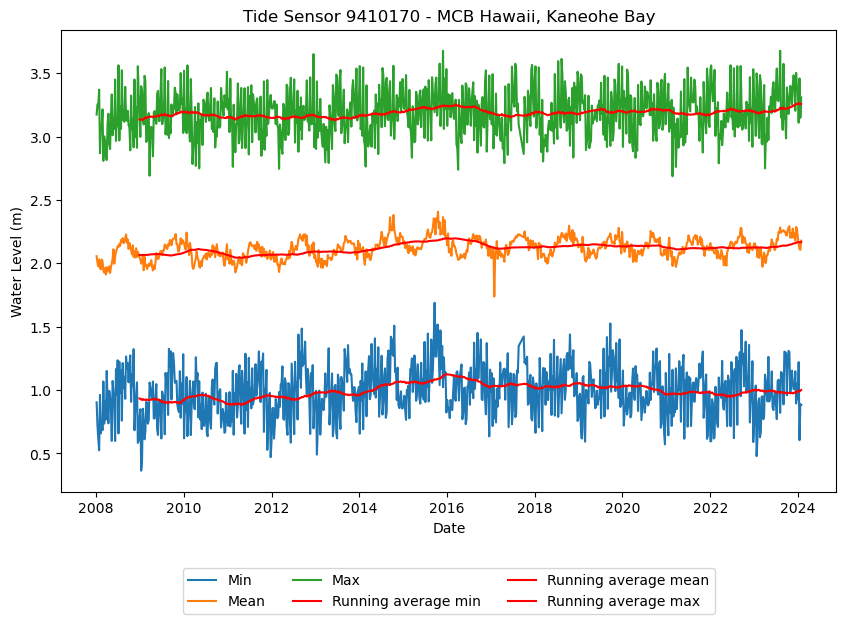

In [9]:
# curating and processing the data and creating plots
curate_tide_sensor_data(tide_sensor_data_df)

In [16]:
# creating a map
create_map(bases_df, tide_sensors_df)

TypeError: Object of type Icon is not JSON serializable